In [28]:
import torch
import torch.utils.data as data
import torch.nn as nn
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")

    # Losowość jest bardzo ważnym elementem trenowania sieci neuronowych (o czym się wkrótce przekonamy).Eksperymentując, chcielibyśmy jednak żeby przy każdym uruchomieniu programu, wynik był taki sam. Tylko w takim przypadku jesteśmy w stanie coś wnioskować. Do zapewnienia możliwości reprodukcji wyników na GPU za pomocą pytorcha służa poniższe komendy:

    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

else:
    device = torch.device("cpu")
print(device.type)

cpu


In [12]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=";")

In [13]:
train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)

In [21]:
classes = Counter(df["quality"])

In [30]:
df.keys().__len__()

12

<BarContainer object of 7 artists>

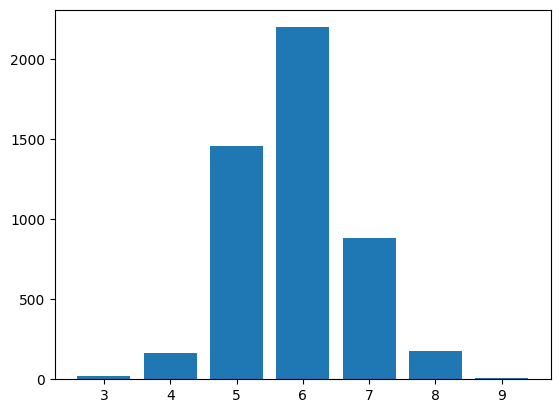

In [26]:
plt.bar(classes.keys(), classes.values())

In [52]:
train_dataset = data.TensorDataset(torch.from_numpy(train.values[:,:-1].astype(np.float32)),torch.from_numpy(train.values[:,-1].astype(np.float32)))

In [53]:
class WineClassifier(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, 32)
        self.act_fn = nn.LeakyReLU()
        self.linear2 = nn.Linear(32, 32)
        self.linear3 = nn.Linear(32, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        x = self.act_fn(x)
        x = self.linear3(x)
        return x

In [54]:
train_data_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [67]:
model = WineClassifier(11, 11)
model.to(device)

WineClassifier(
  (linear1): Linear(in_features=11, out_features=32, bias=True)
  (act_fn): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=11, bias=True)
)

In [68]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}, dtype {param.dtype}")

Parameter linear1.weight, shape torch.Size([32, 11]), dtype torch.float32
Parameter linear1.bias, shape torch.Size([32]), dtype torch.float32
Parameter linear2.weight, shape torch.Size([32, 32]), dtype torch.float32
Parameter linear2.bias, shape torch.Size([32]), dtype torch.float32
Parameter linear3.weight, shape torch.Size([11, 32]), dtype torch.float32
Parameter linear3.bias, shape torch.Size([11]), dtype torch.float32


In [77]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [78]:
loss_module = nn.CrossEntropyLoss()

In [79]:
model.train()
EPOCHS = 100
for epoch in range(EPOCHS):
    for data_inputs, data_labels in train_data_loader:
        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)


        ## Step 3: Calculate the loss
        loss = loss_module(preds, data_labels.long())

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()
    print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.949
Epoch: 1, loss: 0.813
Epoch: 2, loss: 0.844
Epoch: 3, loss: 1.12
Epoch: 4, loss: 1.1
Epoch: 5, loss: 0.905
Epoch: 6, loss: 1.06
Epoch: 7, loss: 1.04
Epoch: 8, loss: 1.25
Epoch: 9, loss: 0.752
Epoch: 10, loss: 0.972
Epoch: 11, loss: 0.831
Epoch: 12, loss: 0.916
Epoch: 13, loss: 0.689
Epoch: 14, loss: 0.906
Epoch: 15, loss: 0.724
Epoch: 16, loss: 0.781
Epoch: 17, loss: 1.26
Epoch: 18, loss: 0.838
Epoch: 19, loss: 0.978
Epoch: 20, loss: 1.35
Epoch: 21, loss: 1.31
Epoch: 22, loss: 1.06
Epoch: 23, loss: 0.834
Epoch: 24, loss: 1.53
Epoch: 25, loss: 0.943
Epoch: 26, loss: 1.08
Epoch: 27, loss: 0.894
Epoch: 28, loss: 1.01
Epoch: 29, loss: 1.01
Epoch: 30, loss: 0.615
Epoch: 31, loss: 0.914
Epoch: 32, loss: 1.16
Epoch: 33, loss: 1.3
Epoch: 34, loss: 1.04
Epoch: 35, loss: 1.38
Epoch: 36, loss: 0.772
Epoch: 37, loss: 0.98
Epoch: 38, loss: 1.14
Epoch: 39, loss: 1.06
Epoch: 40, loss: 0.967
Epoch: 41, loss: 0.765
Epoch: 42, loss: 0.823
Epoch: 43, loss: 1.02
Epoch: 44, loss: 1.09